In [19]:
import networkx as nx
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import sys
import contextlib
import itertools
from math import comb
from numpy import linalg as LA
import math
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
from math import factorial as f
import networkx as nx
import itertools
import scipy

# Moran fixation probability
def theoretic_fixation_moran(nodes,fitness):
    if fitness==1:
        return 1/(nodes)
    else:
        k=(1-1/fitness)/(1-1/(pow(fitness,nodes)))
        return k
    
    

# Enumerating all networks for a given number of nodes n
def get_all_graphs(n):
    rows = sorted(itertools.product(range(2), repeat=nCr(n,2)), key= lambda x: sum(x))

    indices = [sum(range(n-1, n-i-1, -1)) for i in range(n)] + [sum(range(n))]

    graphs = [{node: [j+node+1 for j, edge in enumerate(row[indices[node] : indices[node+1]]) if edge == 1] for node in range(n)} for row in rows]
    return[nx.from_dict_of_lists(x) for x in graphs]
    
    #stackexchange code
    




def T_Mat(G,r):

    if type(G) == nx.classes.graph.Graph :
        n=nx.number_of_nodes(G)
        A=nx.adjacency_matrix(G)
        
        #T is the transition matrix
    elif type(G) == np.ndarray or type(G) == scipy.sparse.csr.csr_matrix or type(G) ==np.matrix :
        A=G
        n=np.shape(A)[0]
      
    
    T=np.zeros((2**(n),2**(n)),dtype='float')
    
    #one-one correspondence bit strings 
    #zero denotes resident in the corresponding vertex in the graph and one the mutant
    lst = list(itertools.product([0, 1], repeat=n))
    bit_strings = np.array(lst)
    
    
    #setting the entries of T, iteratively
    for i in range(2**(n)):
        #finding the entries of bit_strings which correspond to the states with exactly one mutant
        #k is the number of mutants in state i
        k= np.count_nonzero(bit_strings[i]!=0)
        
        for j in range(2**(n)):
            
            #Checking that the corresponding bit strings i and j only differ in one entry
            if LA.norm(bit_strings[i]-bit_strings[j])==1 :
                
                #Checking whether theres an increase or decrease in number of mutants 
                arr=bit_strings[j]-bit_strings[i]
                #new_arr_no_0 contains a single entry, either -1 or 1
                new_arr_no_0 = arr[arr!=0]
                #new_node is the difference node between i and j
                new_node= np.nonzero(arr)[0][0]
                
                #if i==1 and j==0:
                    #print("The sign is",np.sign(new_arr_no_0[0]))
                
                #if there is a gain in mutant number
                if np.sign(new_arr_no_0[0])==1:
                    #s is an array that contains the non-zero indices (mutants)
                    s= np.nonzero(bit_strings[i])[0]
                    
                    for l in s:
                        T[i,j] += A[l,new_node]/(np.sum(A,axis=1)[l])
                    
                    T[i,j]=(r/(r*k+n-k))*T[i,j]
                
                #if there is a drop in mutant number    
                elif np.sign(new_arr_no_0[0])==-1:
                    #t is an array that contains the zero indices (residents)
                    t= np.where(bit_strings[i] == 0)[0]
                    
                    for l in t:
                        T[i,j] += A[l,new_node]/((np.sum(A,axis=1)[l]))     
                    
                    T[i,j]=(1/(r*k+n-k))*T[i,j]
                        
                
            if LA.norm(bit_strings[i])==0 :
                T[i,i]=1
                T[i,j]=0
                    
       
    for i in range(1,2**(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    return T


def matrix_solver(M):
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = int(math.log2(n+2))
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    c=[]
    
    lst = list(itertools.product([0, 1], repeat=m))
    bit_strings = np.array(lst)
    
    for i in range(2**m-1):
        if np.count_nonzero(bit_strings[i] == 1)==1 :
            c.append(i)
    #print(c)
    
    for i in c:
        fixn += fixn_arr[i-1]
    return fixn[0]/m


def switch_matrix_solver(M,N,t):
    if np.shape(M) != np.shape(N):
        print("Matrices have different dimensions!")
        return 0
    
    T= np.matmul(matrix_power(M, t),matrix_power(N, t))
    Q=T[1:-1,1:-1]
    p2=T[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = int(math.log2(n+2))
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    c=[]
    
    lst = list(itertools.product([0, 1], repeat=m))
    bit_strings = np.array(lst)
    
    for i in range(2**m-1):
        if np.count_nonzero(bit_strings[i] == 1)==1 :
            c.append(i)
    #print(c)
    
    for i in c:
        fixn += fixn_arr[i-1]
    return fixn[0]/m
    
    
    
def sum_graph(graph1,graph2):
    graph3 = nx.Graph()
    graph3.add_nodes_from(graph1.nodes())
    elist=list(graph1.edges())+list(graph2.edges())
    graph3.add_edges_from(elist)
    #adding weight
    for i in elist:
        graph3.edges[i]['weight'] = elist.count(i)
    return graph3        

    


def T_weightMat(G,r):
    if type(G) == nx.classes.graph.Graph:
        n=nx.number_of_nodes(G)
        A=nx.adjacency_matrix(G)
        #T is the transition matrix
    elif type(G) == np.ndarray:
        A=G
        n=np.shape(A)[0]
    
    T=np.zeros((2**(n),2**(n)),dtype='float')
    
    #one-one correspondence bit strings 
    #zero denotes resident in the corresponding vertex in the graph and one the mutant
    lst = list(itertools.product([0, 1], repeat=n))
    bit_strings = np.array(lst)
    
    
    #setting the entries of T, iteratively
    for i in range(2**(n)):
        #finding the entries of bit_strings which correspond to the states with exactly one mutant
        #k is the number of mutants in state i
        k= np.count_nonzero(bit_strings[i]!=0)
        
        for j in range(2**(n)):
            
            #Checking that the corresponding bit strings i and j only differ in one entry
            if LA.norm(bit_strings[i]-bit_strings[j])==1 :
                
                #Checking whether theres an increase or decrease in number of mutants 
                arr=bit_strings[j]-bit_strings[i]
                #new_arr_no_0 contains a single entry, either -1 or 1
                new_arr_no_0 = arr[arr!=0]
                #new_node is the difference node between i and j
                new_node= np.nonzero(arr)[0][0]
                
                #if i==1 and j==0:
                    #print("The sign is",np.sign(new_arr_no_0[0]))
                
                #if there is a gain in mutant number
                if np.sign(new_arr_no_0[0])==1:
                    #s is an array that contains the non-zero indices (mutants)
                    s= np.nonzero(bit_strings[i])[0]
                    
                    for l in s:
                        T[i,j] += A[l,new_node]/(G.degree(l,weight='weight'))
                    
                    T[i,j]=(r/(r*k+n-k))*T[i,j]
                
                #if there is a drop in mutant number    
                elif np.sign(new_arr_no_0[0])==-1:
                    #t is an array that contains the zero indices (residents)
                    t= np.where(bit_strings[i] == 0)[0]
                    
                    for l in t:
                        T[i,j] += A[l,new_node]/(G.degree(l,weight='weight'))     
                    
                    T[i,j]=(1/(r*k+n-k))*T[i,j]
                        
                
            if LA.norm(bit_strings[i])==0 :
                T[i,i]=1
                T[i,j]=0
                    
       
    for i in range(1,2**(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    return T


# permuting the labels of a network
def permute(G):
    A=nx.adjacency_matrix(G).todense()
    P=np.random.permutation(np.identity(G.number_of_nodes()))
    T= np.matmul(np.matmul(P,A),np.transpose(P))
    return T

# Analytical expression for the fixation probability of star graph
def star_anfixn(N,r):
    fixn=0
    a=N-1
    if r==1:
        fixn = 1/N
        return fixn
    else:
        num = 1-(((N-1)*(r+a))/(N*(r*(r*a+1))))-((1/N)*((r*a+1)/((r*(r+a)))))
        den = 1-(r**(-N))*(((r+a)/(r*a+1))**(N-2))
        return num/den
    

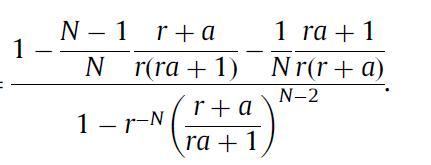

## Death-birth updating

In [1]:
def T_WeightMat_dB(G,r):

    if type(G) == nx.classes.graph.Graph :
        n=nx.number_of_nodes(G)
        A=nx.adjacency_matrix(G)
        
        #T is the transition matrix
    elif type(G) == np.ndarray or type(G) == scipy.sparse.csr.csr_matrix or type(G) ==np.matrix :
        A=G
        n=np.shape(A)[0]
      
    
    T=np.zeros((2**(n),2**(n)),dtype='float')
    
    #one-one correspondence bit strings 
    #zero denotes resident in the corresponding vertex in the graph and one the mutant
    lst = list(itertools.product([0, 1], repeat=n))
    bit_strings = np.array(lst)
    
    
    #setting the entries of T, iteratively
    for i in range(2**(n)):
        #finding the entries of bit_strings which correspond to the states with exactly one mutant
        #k is the number of mutants in state i
        k= np.count_nonzero(bit_strings[i]!=0)
        
        for j in range(2**(n)):
            
            #Checking that the corresponding bit strings i and j only differ in one entry
            if LA.norm(bit_strings[i]-bit_strings[j])==1 :
                
                #Checking whether theres an increase or decrease in number of mutants 
                arr=bit_strings[j]-bit_strings[i]
                #new_arr_no_0 contains a single entry, either -1 or 1
                new_arr_no_0 = arr[arr!=0]
                #new_node is the difference node between i and j
                new_node= np.nonzero(arr)[0][0]
                
                #if i==1 and j==0:
                    #print("The sign is",np.sign(new_arr_no_0[0]))
                #s is an array that contains the non-zero indices (mutants)
                s= np.nonzero(bit_strings[i])[0]
                m=0
                for l in s:
                    m += A[l,new_node]
                    
                #if there is a gain in mutant number
                if np.sign(new_arr_no_0[0])==1:
                    T[i,j]=(1/n)*((r*m)/(r*m+G.degree(new_node,weight='weight')-m))
                
                #if there is a drop in mutant number    
                elif np.sign(new_arr_no_0[0])==-1:
                    T[i,j]=(1/n)*((G.degree(new_node,weight='weight')-m)/(r*m+G.degree(new_node,weight='weight')-m))
                        
                
            if LA.norm(bit_strings[i])==0 :
                T[i,i]=1
                T[i,j]=0
                    
       
    for i in range(1,2**(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    return T


### Weighted complete graph w1,w2

In [167]:
# returns the transition probability matrix for the weighted complete graph characterised by (w_1,w_2)
def weights_complete_graph(w1,w2,N1,N2,r):
    N=N1+N2
    bit_list = []
    for i in range(N1+1):
        for j in range(N2+1):
            #for k in range(n+1):
            bit_list.append([i,j])   
            
              
    string_list = np.array(bit_list)
    T=np.zeros(((N1+1)*(N2+1),(N1+1)*(N2+1)),dtype='float')
    s1=w1*(N1-1)+N2
    s2=w2*(N2-1)+N1
    for i in range(1,(N1+1)*(N2+1)):
        for j in range((N1+1)*(N2+1)):
            a=string_list[i][0]
            b=string_list[i][1]
            F=(a+b)*r+(N-a-b)
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]-string_list[j][0]==1:
                    T[i,j]=((N1-a)/F)*(w1*a/s1)+((N2-b)/F)*((a)/s2)                                
                elif string_list[j][0]-string_list[i][0]==1:
                    T[i,j]=(r*a/F)*(w1*(N1-a)/s1)+(r*b/F)*((N1-a)/s2)
                elif string_list[i][1]-string_list[j][1]==1:
                    T[i,j]=((N1-a)/F)*(b/s1)+((N2-b)/F)*((w2*b)/s2)  
                elif string_list[j][1]-string_list[i][1]==1:
                    T[i,j]=(r*a/F)*((N2-b)/s1)+(r*b/F)*(w2*(N2-b)/s2)

                        
                        

    
    for i in range(1,(N1+1)*(N2+1)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
                        
    return T

# returns the fixation probability of the weighted complete graph (w_1,w_2) for given (N1,N2,r)
def matrix_complete_weight_solver(w1,w2,N1,N2,r):
    M=weights_complete_graph(w1,w2,N1,N2,r)
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #N is the number of nodes in the graph
    N=N1+N2
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    
    fixn = fixn_arr[0]*(N2/N)+fixn_arr[N2]*(N1/N)
    #print(fixn_arr)
    return fixn[0]

In [111]:
matrix_complete_weight_solver(1,1,2,4,1)

0.16666666666666682

## Weighted star

In [4]:
# returns the transition probability matrix for the weighted star graph characterised by (m_1,m_2,w)
def weighted_star_Tmat(m1,m2,w,r):#n nodes
    #Check if G is indeed a star graph
    T=np.zeros((2*(m1+1)*(m2+1),(2*(m1+1)*(m2+1))),dtype='float')
    
    bit_list = []
    for i in range(2):
        for j in range(m1+1):
            for k in range(m2+1):
                bit_list.append([i,j,k])
    
    string_list = np.array(bit_list)
    s=w*m1+m2
    for i in range(1,(2*(m1+1)*(m2+1))):
        a=string_list[i][1]
        b=string_list[i][2]
        F=r*(string_list[i][0]+a+b)+(m1+m2+1-(string_list[i][0]+a+b))
        for j in range((2*(m1+1)*(m2+1))):
                if LA.norm(string_list[i]-string_list[j])==1:
                    if string_list[i][0]==0:
                    
                        if string_list[j][0]==1:
                            T[i,j]= r*(a+b)/F
                        else:
                            if string_list[i][1]-string_list[j][1]==1:
                                T[i,j]= ((1/F))*(w*a/s)
                            elif string_list[i][2]-string_list[j][2]==1:
                                T[i,j]= ((1/F))*(b/s)
                            
                            
                    elif string_list[i][0]==1:
                    
                        if string_list[j][0]==0:
                            T[i,j]= ((m1-a)+(m2-b))/F
                        else:
                            if string_list[j][1]-string_list[i][1]==1:
                                T[i,j]= (r/F)*w*(m1-a)/(s)
                            elif string_list[j][2]-string_list[i][2]==1:
                                T[i,j]= (r/F)*(m2-b)/(s)
                            
                            
                            
    for i in range(1,(2*(m1+1)*(m2+1))):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1

    
    return T



# returns the fixation probability matrix for the weighted star graph characterised by (m_1,m_2,w)
def weighted_star_solver(m1,m2,w,r):
    M=weighted_star_Tmat(m1,m2,w,r)
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #m is the number of nodes in the graph
    m = m1+m2+1
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    #print(m1,m2,m)
    #print(m1*m2+m1+m2)
    fixn = fixn_arr[0]*(m2/m)+fixn_arr[m2]*((m1)/m)+fixn_arr[m1*m2+m1+m2]*(1/m)
    return fixn[0]


## Simulation

In [ ]:
def unicolor_all_nodes(graph):
    for i in range (0,graph.number_of_nodes()):
        graph.nodes[i]['color']='red'
        

def simulate(graph,fitness):
    unicolor_all_nodes(graph)
    #A = nx.adjacency_matrix(graph)
    
    
    #random mutation
    graph.nodes[np.random.randint(0,graph.number_of_nodes())]['color']='blue'
    #print(graph.nodes.data())
    #Array with colors of the nodes of the graph,
    Color_Array = np.empty(graph.number_of_nodes(), dtype='object')  
    
    #Color_array updates it's colors according to mutation
    for i in range(0,graph.number_of_nodes()):
        Color_Array[i]=graph.nodes[i]['color']    
    
    #init variables
    red=0
    redprob=0
    contenderlist=[]
    contender=0
    victimlist=[]
    victim=0
    
    #loop runs until all nodes are same colored
    while len(np.unique(Color_Array)) > 1:
        
        contenderlist=[]
        victimlist=[]
        red=0
        
        for i in range(0,graph.number_of_nodes()):
            if graph.nodes[i]['color']=='red':
                red = red + 1
        #print(red," resident remain")
        
        redprob = (red)/(fitness*(graph.number_of_nodes()-red)+red)
        
        ranBirth = random.uniform(0, 1)
        
        if ranBirth <= redprob :
            for i in range(0,graph.number_of_nodes()):
                if graph.nodes[i]['color']=='red':
                    contenderlist.append(i)
        else:
            for i in range(0,graph.number_of_nodes()):
                if graph.nodes[i]['color']=='blue':
                    contenderlist.append(i)
                    
        contender=random.choice(contenderlist)
        
        #now we select the victim amongst the neighbours of the contender
        
        for i in range(0,graph.number_of_nodes()):
            if int(i in graph.neighbors(contender)) == 1:
                victimlist.append(i)
        
        victim = random.choice(victimlist)
        graph.nodes[victim]['color'] = graph.nodes[contender]['color']
        
        Color_Array[victim]= graph.nodes[contender]['color']

        
def simulation_count(graph,n,r):
    
    blue_victory=0
    red_victory=0
        
        
    for i in range(n):
        simulate(graph,r)

            
        if graph.nodes[1]['color']=='red':
                red_victory=red_victory+1
        elif graph.nodes[1]['color']=='blue':
                blue_victory=blue_victory+1
                    
        #return the fixation prob
    prob = blue_victory/(n)
    return prob


def weighted_simulate(graph,fitness):
    unicolor_all_nodes(graph)
    #A = nx.adjacency_matrix(graph)
    
    
    #random mutation
    graph.nodes[np.random.randint(0,graph.number_of_nodes())]['color']='blue'

    #Array with colors of the nodes of the graph,
    Color_Array = np.empty(graph.number_of_nodes(), dtype='object')  
    
    #Color_array updates it's colors according to mutation
    for i in range(0,graph.number_of_nodes()):
        Color_Array[i]=graph.nodes[i]['color']    
    
    #init variables
    red=0
    redprob=0
    contenderlist=[]
    contender=0
    victimlist=[]
    victim=0
    
    #loop runs until all nodes are same colored
    while len(np.unique(Color_Array)) > 1:
        
        contenderlist=[]
        victimlist=[]
        red=0
        
        for i in range(0,graph.number_of_nodes()):
            if graph.nodes[i]['color']=='red':
                red = red + 1
        #print(red," resident remain")
        
        redprob = (red)/(fitness*(graph.number_of_nodes()-red)+red)
        
        ranBirth = random.uniform(0, 1)
        
        if ranBirth <= redprob :
            for i in range(0,graph.number_of_nodes()):
                if graph.nodes[i]['color']=='red':
                    contenderlist.append(i)
        else:
            for i in range(0,graph.number_of_nodes()):
                if graph.nodes[i]['color']=='blue':
                    contenderlist.append(i)
                    
        contender=random.choice(contenderlist)
        
        #now we select the victim amongst the neighbours of the contender
        
        nghbr_list=[n for n in nx.all_neighbors(graph,contender)]
        if len(nghbr_list)==0:
            continue
        weights_nbr=[]
        for nghbr in nghbr_list:
            weights_nbr.append(graph[contender][nghbr]["weight"])
        victim = random.choices(nghbr_list, weights=weights_nbr)[0]
       
        graph.nodes[victim]['color'] = graph.nodes[contender]['color']
        
        Color_Array[victim]= graph.nodes[contender]['color']
         

        
def weighted_simulation_count(graph,n,r):
    
    blue_victory=0
    red_victory=0
        
        
    for i in range(n):
        weighted_simulate(graph,r)

            
        if graph.nodes[1]['color']=='red':
                red_victory=red_victory+1
        elif graph.nodes[1]['color']=='blue':
                blue_victory=blue_victory+1
                    
        #return the fixation prob
    prob = blue_victory/(n)
    return prob
        
        